# Goal : Predict CO2 uptake 



In [3]:
#Import libraries

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [42]:
#Read data 
df_all = pd.read_excel("Processed 527 datapoints.xlsx")

In [43]:
df_all.describe()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),S (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
count,527.000000,499.000000,317.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,1488.150152,0.800020,0.516845,76.322676,1.684080,3.262524,18.173321,0.125351,18.462998,0.866636,3.453549
std,728.611596,0.448172,0.272742,12.591289,1.585595,3.712314,11.632111,0.930828,11.009418,0.311198,1.567808
min,2.480000,0.020000,0.040000,40.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.360000
25%,955.500000,0.480000,0.310000,69.830000,0.000000,0.715000,9.920000,0.000000,0.000000,1.000000,2.335000
50%,1420.000000,0.690000,0.480000,79.100000,1.500000,2.160000,15.430000,0.000000,25.000000,1.000000,3.460000
75%,1960.000000,1.030000,0.690000,85.330000,2.410000,4.450000,22.910000,0.000000,25.000000,1.000000,4.345000
max,3337.000000,3.090000,1.290000,96.960000,6.010000,38.150000,54.000000,13.200000,30.000000,1.013250,8.200000


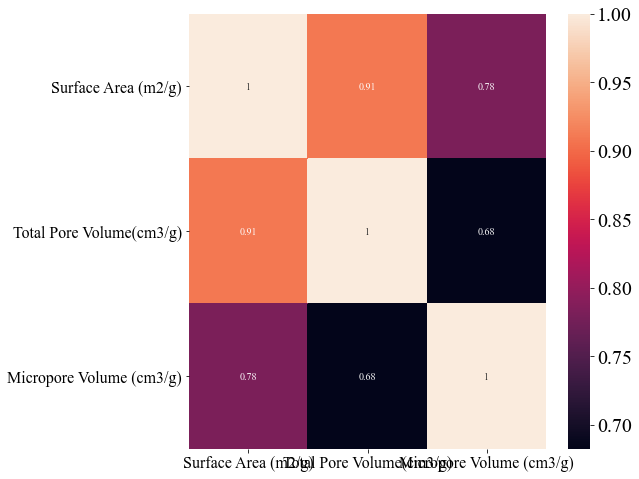

In [44]:
# Subset of master data with textural properties only

df_all[['Surface Area (m2/g)','Total Pore Volume(cm3/g)','Micropore Volume (cm3/g)']]

# High correlation among textural properties, SA, TPV MV.

plt.figure(figsize=(8,8))
sns.heatmap(df_all[['Surface Area (m2/g)','Total Pore Volume(cm3/g)','Micropore Volume (cm3/g)']].corr(), annot=True)

plt.xticks(rotation = 0, fontsize= 16, fontname = "Times New Roman")
plt.yticks(rotation = 0, fontsize= 16, fontname = "Times New Roman")
plt.show()

In [45]:
df_all.head()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),S (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
0,1281.6,0.71,0.32,69.22,3.99,0.08,26.30,0.40,25,1.0,2.625000
1,1012.6,0.56,0.22,64.83,3.64,0.38,30.77,0.38,25,1.0,2.586364
2,1408.8,0.83,0.36,72.41,3.63,0.01,23.59,0.37,25,1.0,2.920455
3,1403.9,0.85,0.33,69.51,4.35,0.76,24.94,0.44,25,1.0,2.438636
4,841.3,0.36,NaN,68.43,0.00,31.09,0.48,0.00,25,1.0,3.230000


In [46]:
# MPV and TPV prediction 
# Due to high correlation among the textural properties, we could create a simple model to predict and impute null values for MPV and TPV

def feature_impute(df_all, target):
    '''
    Evaluates different models to predict and impute null values.
    Models used were LR, RF, XGB, LGBM. 
    RF was superior (based on R2) so it was used.
    Args:
        df_all: DataFrame
        target: feature name to be imputed
    
    Returns:
        DataFrame with imputed data
    '''
    df_mv = df_all[["Surface Area (m2/g)", target]].copy()
    df_mv = df_mv.dropna()

    x = np.array(df_mv["Surface Area (m2/g)"]).reshape(-1,1)
    y = np.array(df_mv[target]).reshape(-1,1)

    x_train, x_test , y_train , y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

    print("LR:")
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    scores = cross_val_score(lr, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("RF: ")
    rf = RandomForestRegressor(random_state =42)
    rf.fit(x_train, y_train)
    pred = rf.predict(x_test)
    scores = cross_val_score(rf, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("LGB: ")
    lg = LGBMRegressor(seed = 42)
    lg.fit(x_train, y_train)
    pred = lg.predict(x_test)
    scores = cross_val_score(lg, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("XGB: ")
    xg = XGBRegressor()
    xg.fit(x_train, y_train)
    pred = xg.predict(x_test)
    scores = cross_val_score(xg, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))
    
    # As RF is best:
    name = target + "_imputed"
    p = rf.predict(np.array(df_all["Surface Area (m2/g)"]).reshape(-1,1))
    df_all[name] = p
    return df_all

In [47]:
feature_impute(df_all, "Total Pore Volume(cm3/g)")
feature_impute(df_all, "Micropore Volume (cm3/g)")

LR:
Train R2: 0.832 (+/- 0.046) 

Test R2: 0.801

RF: 


<ipython-input-46-6afc8261e3b5>:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
C:\Users\msuva\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\msuva\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\msuva\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

Train R2: 0.847 (+/- 0.025) 

Test R2: 0.926

LGB: 
Train R2: 0.823 (+/- 0.046) 

Test R2: 0.828

XGB: 
Train R2: 0.826 (+/- 0.048) 

Test R2: 0.931

LR:
Train R2: 0.576 (+/- 0.069) 

Test R2: 0.710

RF: 


<ipython-input-46-6afc8261e3b5>:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
C:\Users\msuva\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\msuva\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\msuva\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

Train R2: 0.633 (+/- 0.085) 

Test R2: 0.687

LGB: 
Train R2: 0.530 (+/- 0.131) 

Test R2: 0.648

XGB: 


C:\Users\msuva\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Train R2: 0.602 (+/- 0.105) 

Test R2: 0.673



,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),S (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g),Total Pore Volume(cm3/g)_imputed,Micropore Volume (cm3/g)_imputed
0,1281.6,0.71,0.32,69.22,3.99,0.08,26.30,0.40,25,1.00,2.625000,0.5625,0.380400
1,1012.6,0.56,0.22,64.83,3.64,0.38,30.77,0.38,25,1.00,2.586364,0.5385,0.280000
2,1408.8,0.83,0.36,72.41,3.63,0.01,23.59,0.37,25,1.00,2.920455,0.6658,0.406900
3,1403.9,0.85,0.33,69.51,4.35,0.76,24.94,0.44,25,1.00,2.438636,0.8071,0.403000
4,841.3,0.36,NaN,68.43,0.00,31.09,0.48,0.00,25,1.00,3.230000,0.4658,0.304900
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,2230.0,1.03,0.89,86.50,0.00,0.40,11.90,0.00,25,0.15,0.980000,1.0531,0.846667
523,1950.0,0.88,0.72,84.80,0.00,0.40,11.90,0.00,25,0.15,1.140000,0.9402,0.647400
524,1230.0,0.90,NaN,66.41,0.00,8.33,25.26,4.00,0,1.00,5.140000,0.8453,0.229200
525,2380.0,1.64,NaN,77.93,0.00,4.94,17.13,1.12,0,1.00,5.450000,1.4435,0.698800


In [48]:
df_all["Total Pore Volume(cm3/g)"] = df_all["Total Pore Volume(cm3/g)"].fillna(df_all["Total Pore Volume(cm3/g)_imputed"])
df_all["Micropore Volume (cm3/g)"] = df_all["Micropore Volume (cm3/g)"].fillna(df_all["Micropore Volume (cm3/g)_imputed"])
df_all["Temp (°C)"]= df_all["Temp (°C)"].fillna(25)

In [49]:
# drop unrequired featues
df = df_all.drop(["S (%)",'Total Pore Volume(cm3/g)_imputed','Micropore Volume (cm3/g)_imputed'], axis = 1)

In [50]:
#Processed dataset
df.head()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
0,1281.6,0.71,0.3200,69.22,3.99,0.08,26.30,25,1.0,2.625000
1,1012.6,0.56,0.2200,64.83,3.64,0.38,30.77,25,1.0,2.586364
2,1408.8,0.83,0.3600,72.41,3.63,0.01,23.59,25,1.0,2.920455
3,1403.9,0.85,0.3300,69.51,4.35,0.76,24.94,25,1.0,2.438636
4,841.3,0.36,0.3049,68.43,0.00,31.09,0.48,25,1.0,3.230000


In [51]:
#Defining the input features and target variable 

x = df.drop("CO2 uptake (mmol/g)",axis=1)
y = df["CO2 uptake (mmol/g)"]

#spliting the dataset into 85:15 ratio

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [52]:
names = df.columns[0:9]
names

Index(['Surface Area (m2/g)', 'Total Pore Volume(cm3/g)',
       'Micropore Volume (cm3/g)', 'C (%)', 'H (%)', 'N (%)', 'O (%)',
       'Temp (°C)', 'Pressure (bar)'],
      dtype='object')

In [53]:
x_train

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar)
464,1577.0,0.6800,0.5623,79.18,2.11,2.60,16.11,25,1.00
320,397.3,0.2394,0.1602,83.29,0.17,1.58,14.96,25,1.00
227,1606.0,0.9700,0.7800,71.19,2.88,4.02,21.91,25,1.00
520,1600.0,0.6500,0.5400,84.40,0.00,1.30,12.60,25,0.15
425,1699.0,0.8900,0.4978,70.32,1.98,9.54,18.16,0,1.00
...,...,...,...,...,...,...,...,...,...
71,1480.0,0.7100,0.4800,89.42,1.46,2.08,7.04,25,0.15
106,1511.0,0.6500,0.5400,78.20,1.90,0.00,19.90,25,1.00
270,1721.0,0.9200,0.7500,61.53,1.45,2.54,34.48,25,1.00
435,2957.0,1.7900,0.5600,59.50,0.00,2.50,38.00,0,1.00


The training R2 is: 0.918
The test R2 is: 0.804 
MSE: 0.521
RMSE: 0.722
The mean training accuracy is: 0.764


C:\Users\msuva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


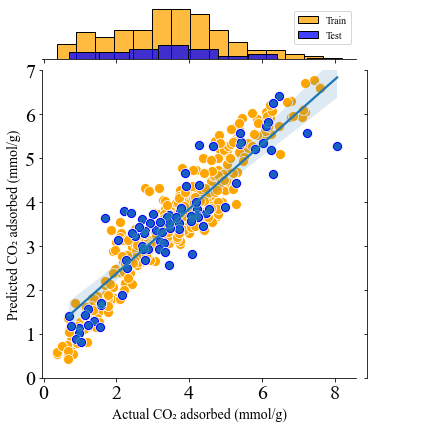

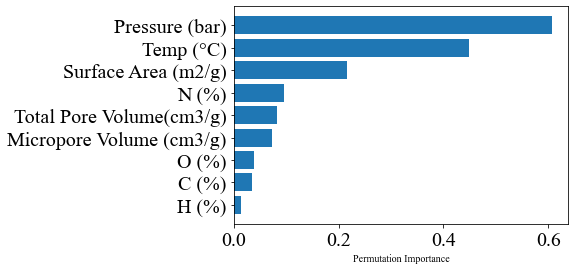

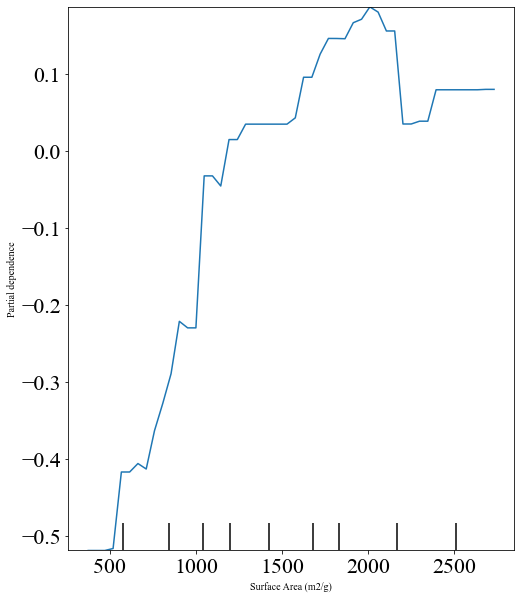

In [54]:
# Fitting GBDT Regression to the entire data (default)

from sklearn.ensemble import GradientBoostingRegressor
model =  GradientBoostingRegressor(random_state=42)

model.fit(x_train, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train,y_train)
print("The training R2 is: %.3f" % model.score(x_train, y_train))
print("The test R2 is: %.3f "% model.score(x_test, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt


y_predicted = model.predict(x_test)

# The mean squared error & Variance
print("MSE: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))


#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid(y_test, y_predicted)
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)
plt.ylim(0, 7)
plt.xlim(0, 7)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", fontsize =14, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])

plt.show()

# PERMUTATION IMPORTANCE
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, x_train, y_train)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

#PDP PLOTS
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

fig, ax = plt.subplots(figsize =(8, 10))
plot_partial_dependence(model, x_train,['Surface Area (m2/g)'],feature_names = names, target = 0, n_jobs = 3, grid_resolution = 50, ax=ax)
plt.tick_params(axis = 'x', labelsize = 22)
plt.tick_params(axis = 'y', labelsize = 22)
ax.set_xlabel('Temperature', fontsize='large')
ax.set_ylabel('PI', fontsize='large')

plt.show()

In [56]:
x_train.head()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar)
464,1577.0,0.6800,0.5623,79.18,2.11,2.60,16.11,25,1.00
320,397.3,0.2394,0.1602,83.29,0.17,1.58,14.96,25,1.00
227,1606.0,0.9700,0.7800,71.19,2.88,4.02,21.91,25,1.00
520,1600.0,0.6500,0.5400,84.40,0.00,1.30,12.60,25,0.15
425,1699.0,0.8900,0.4978,70.32,1.98,9.54,18.16,0,1.00


The training R2 is: 0.982
The test R2 is: 0.836 
MSE: 0.434
RMSE: 0.659
The mean training accuracy is: 0.805


C:\Users\msuva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


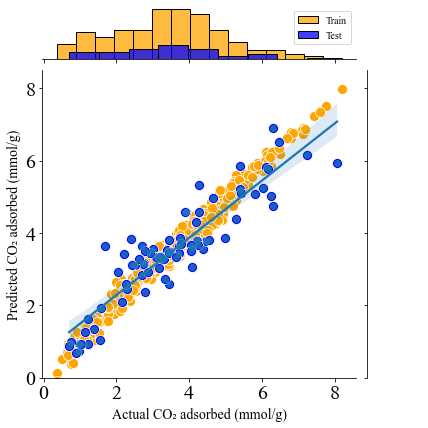

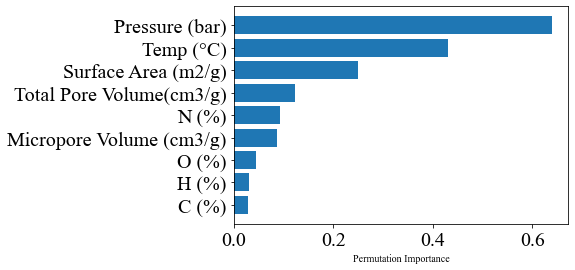

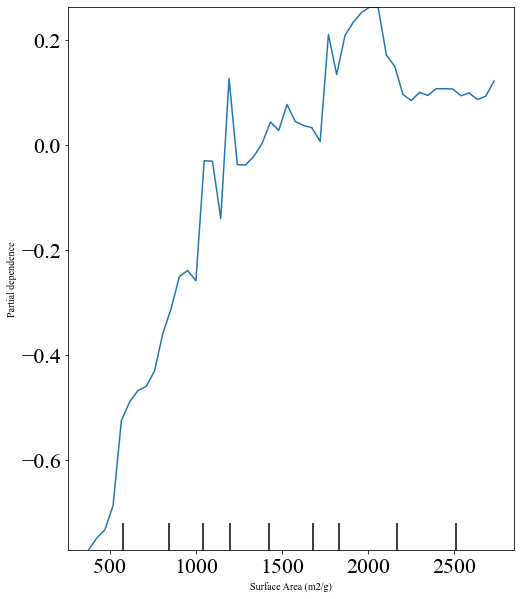

In [57]:
# Fitting optimized GBDT Regression to the entire data

# Say, "the default sans-serif font is COMIC SANS"
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


# Then, "ALWAYS use sans-serif fonts"
#matplotlib.rcParams['font.family'] = "sans-serif"

from sklearn.ensemble import GradientBoostingRegressor
model =  GradientBoostingRegressor(learning_rate= 0.05, max_depth = 4, min_samples_leaf = 1, min_samples_split = 2, 
                                   n_estimators = 300, subsample = 0.5, random_state=42)

model.fit(x_train, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train,y_train)
print("The training R2 is: %.3f" % model.score(x_train, y_train))
print("The test R2 is: %.3f "% model.score(x_test, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model.predict(x_test)

# The mean squared error & Variance
print("MSE: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))


#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid(y_test, y_predicted)
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)
plt.ylim(0, 8.5)
plt.xlim(0, 8.5)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", fontsize =14, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])

plt.show()

# PERMUTATION IMPORTANCE
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, x_train, y_train)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

#PDP PLOTS
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

fig, ax = plt.subplots(figsize =(8, 10))
plot_partial_dependence(model, x_train,['Surface Area (m2/g)'],feature_names = names, target = 0, n_jobs = 3, grid_resolution = 50, ax=ax)
plt.tick_params(axis = 'x', labelsize = 22)
plt.tick_params(axis = 'y', labelsize = 22)
ax.set_xlabel('SA', fontsize='large')
ax.set_ylabel('PI', fontsize='large')

plt.show()


C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndar

The training R2 is: 0.916
The test R2 is: 0.773 
MSE: 0.601
RMSE: 0.775


C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


The mean training accuracy is: 0.782


C:\Users\msuva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


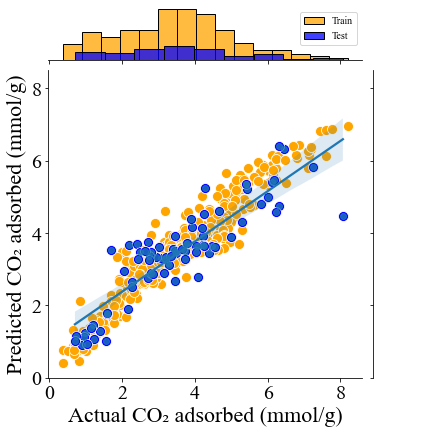

In [58]:
# Fitting optimized XGB Regression to the entire data

import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 

from xgboost import XGBRegressor
model =  XGBRegressor(colsample_bytree = 1, eta = 0.05, eval_metric = 'rmse', 
                        max_depth = 4, n_estimators = 100, seed = 42, subsample = 0.5)

model.fit(x_train, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train,y_train)
print("The training R2 is: %.3f" % model.score(x_train, y_train))
print("The test R2 is: %.3f "% model.score(x_test, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt


y_predicted = model.predict(x_test)

# The mean squared error & Variance
print("MSE: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))


#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid(y_test, y_predicted)
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)
plt.ylim(0, 8.5)
plt.xlim(0, 8.5)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", fontsize =22, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])
plt.locator_params(tight=None, nbins=5)

plt.show()


The training R2 is: 0.917
The test R2 is: 0.778 
MSE: 0.589
RMSE: 0.767
The mean training accuracy is: 0.784


C:\Users\msuva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


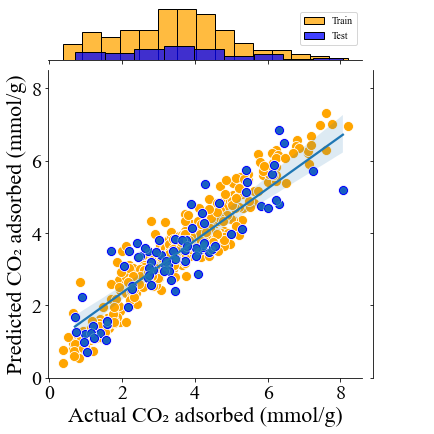

In [59]:
# Fitting optimized LGBM Regression to the entire data

import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


from lightgbm import LGBMRegressor
model =  LGBMRegressor(boosting_type = 'dart', colsample_bytree = 1, learning_rate = 0.2,
                        max_depth = 4, n_estimators = 300, num_leaves = 5, reg_lambda = 0.8, subsample = 1)

model.fit(x_train, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train,y_train)
print("The training R2 is: %.3f" % model.score(x_train, y_train))
print("The test R2 is: %.3f "% model.score(x_test, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt


y_predicted = model.predict(x_test)

# The mean squared error & Variance
print("MSE: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))


#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid(y_test, y_predicted)
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)
plt.ylim(0, 8.5)
plt.xlim(0, 8.5)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", fontsize =22, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])
plt.locator_params(tight=None, nbins=5)
plt.show()


# RPC sub-dataset evaluation

In [60]:
# The first 194 datapoints in the excel sheet belong to RPC subset
df_RPC = df[:195]
df_RPC.head()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
0,1281.6,0.71,0.3200,69.22,3.99,0.08,26.30,25,1.0,2.625000
1,1012.6,0.56,0.2200,64.83,3.64,0.38,30.77,25,1.0,2.586364
2,1408.8,0.83,0.3600,72.41,3.63,0.01,23.59,25,1.0,2.920455
3,1403.9,0.85,0.3300,69.51,4.35,0.76,24.94,25,1.0,2.438636
4,841.3,0.36,0.3049,68.43,0.00,31.09,0.48,25,1.0,3.230000


In [61]:
#Defining the input features and target variable and data split

x1 = df_RPC.drop("CO2 uptake (mmol/g)",axis=1)
y1 = df_RPC["CO2 uptake (mmol/g)"]

x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.15, random_state=42)

The training R2 is: 0.998
The test R2 is: 0.886 
MSE: 0.311
RMSE: 0.558
The mean training accuracy is: 0.881


C:\Users\msuva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


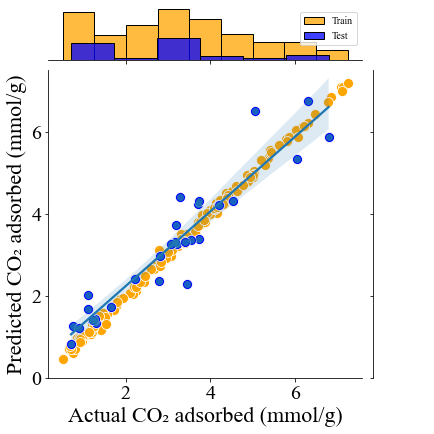

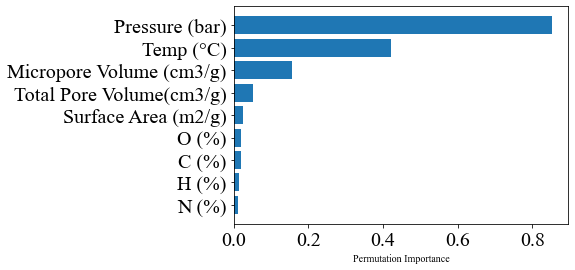

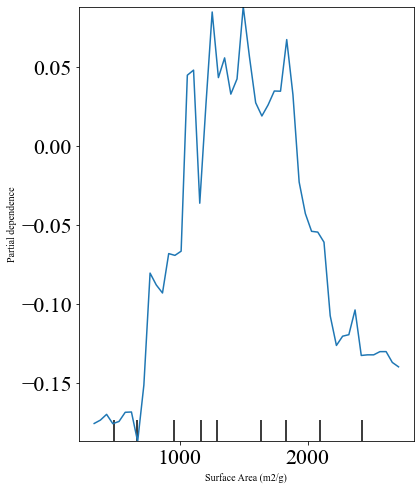

In [62]:
# Fitting RPC dataset Regression with GBT

import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


model =  GradientBoostingRegressor(learning_rate= 0.05, max_depth = 4, min_samples_leaf = 1, min_samples_split = 2, 
                                   n_estimators = 300, subsample = 0.5)

model.fit(x_train, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train,y_train)
print("The training R2 is: %.3f" % model.score(x_train, y_train))
print("The test R2 is: %.3f "% model.score(x_test, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model.predict(x_test)

# The mean squared error & Variance
print("MSE: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))


#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid(y_test, y_predicted)
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)
#sns.lineplot(x=y_test, y=y_predicted, ax=g.ax_joint)
plt.ylim(0, 7.5)
plt.xlim(0, 7.5)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", fontsize =22, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])
plt.locator_params(tight=None, nbins=4)

plt.show()

# PERMUTATION IMPORTANCE
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, x_train, y_train)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


#PDP PLOTS
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence

names= df_RPC.columns[0:9]
fig, ax = plt.subplots(figsize =(6, 8))
plot_partial_dependence(model, x_train,['Surface Area (m2/g)'],feature_names = names, target = 0, n_jobs = 3, grid_resolution = 50, ax=ax)
plt.tick_params(axis = 'x', labelsize = 22)
plt.tick_params(axis = 'y', labelsize = 22)

plt.show()

C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndar

The training R2 is: 0.974
The test R2 is: 0.885 
MSE: 0.314
RMSE: 0.560


C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable

The mean training accuracy is: 0.880


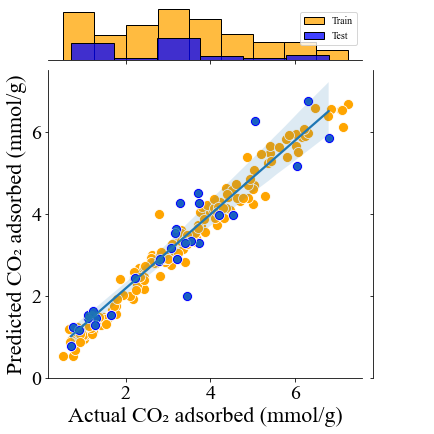

In [63]:
# Fitting RPC dataset  with optimized XGB


import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 

model =  XGBRegressor(colsample_bytree = 1, eta = 0.05, eval_metric = 'rmse', 
                        max_depth = 4, n_estimators = 100, seed = 42, subsample = 0.5)


model.fit(x_train, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train,y_train)
print("The training R2 is: %.3f" % model.score(x_train, y_train))
print("The test R2 is: %.3f "% model.score(x_test, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model.predict(x_test)

# The mean squared error & Variance
print("MSE: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))

#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid(y_test, y_predicted)
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)
plt.ylim(0, 7.5)
plt.xlim(0, 7.5)


g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", fontsize =22, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])
plt.locator_params(tight=None, nbins=4)

plt.show()

The training R2 is: 0.967
The test R2 is: 0.882 
MSE: 0.323
RMSE: 0.568
The mean training accuracy is: 0.860


C:\Users\msuva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


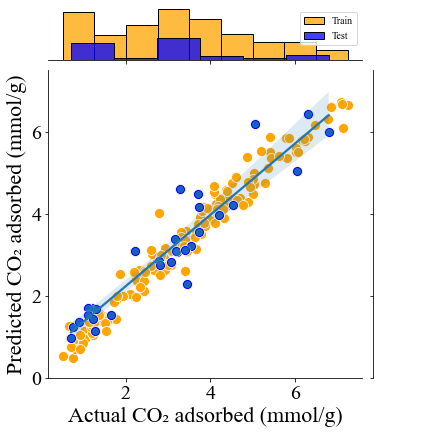

In [64]:
# Fitting RPC dataset with optimized LGBM


import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 

model =  LGBMRegressor(boosting_type = 'dart', colsample_bytree = 1, learning_rate = 0.2,
                        max_depth = 4, n_estimators = 300, num_leaves = 5, reg_lambda = 0.8, subsample = 1)


model.fit(x_train, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train,y_train)
print("The training R2 is: %.3f" % model.score(x_train, y_train))
print("The test R2 is: %.3f "% model.score(x_test, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt


y_predicted = model.predict(x_test)

# The mean squared error & Variance
print("MSE: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))


#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid(y_test, y_predicted)
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)
plt.ylim(0, 7.5)
plt.xlim(0, 7.5)


g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", fontsize =22, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])
plt.locator_params(tight=None, nbins=4)

plt.show()

# HDPC sub-dataset

In [65]:
#The HDPC dataset starts from the 195th row in the excel sheet

df_HDPC = df[195:]
df_HDPC.tail()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
522,2230.0,1.03,0.8900,86.50,0.0,0.40,11.90,25,0.15,0.98
523,1950.0,0.88,0.7200,84.80,0.0,0.40,11.90,25,0.15,1.14
524,1230.0,0.90,0.2292,66.41,0.0,8.33,25.26,0,1.00,5.14
525,2380.0,1.64,0.6988,77.93,0.0,4.94,17.13,0,1.00,5.45
526,2700.0,1.33,1.1064,80.95,0.0,3.45,15.60,0,1.00,4.27


In [66]:
#Define the input and target feature and data split 

x2 = df_HDPC.drop("CO2 uptake (mmol/g)",axis=1)
y2 = df_HDPC["CO2 uptake (mmol/g)"]

x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.15, random_state=42)

The training R2 is: 0.988
The test R2 is: 0.765 
MSE: 0.517
RMSE: 0.719
The mean training accuracy is: 0.740


C:\Users\msuva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


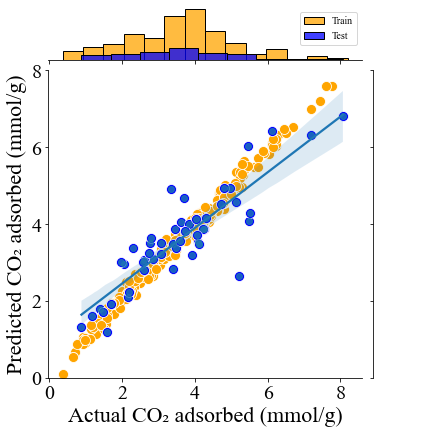

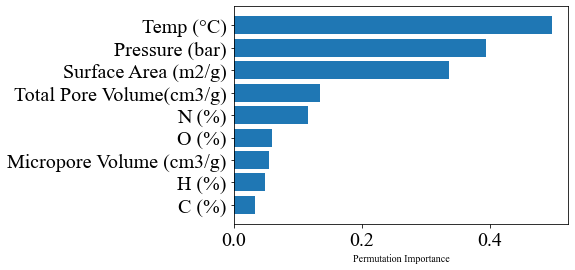

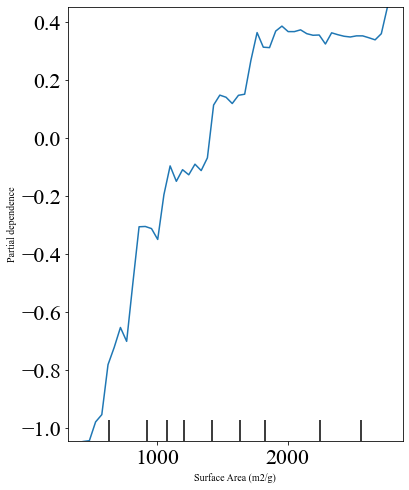

In [67]:
# Fitting HDPC dataset with optimized GBT

import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 

model =  GradientBoostingRegressor(learning_rate= 0.05, max_depth = 4, min_samples_leaf = 1, min_samples_split = 2, 
                                   n_estimators = 300, subsample = 0.5)


model.fit(x_train, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train,y_train)
print("The training R2 is: %.3f" % model.score(x_train, y_train))
print("The test R2 is: %.3f "% model.score(x_test, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt


y_predicted = model.predict(x_test)

# The mean squared error & Variance
print("MSE: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))

#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid(y_test, y_predicted)
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)
plt.ylim(0, 8)
plt.xlim(0, 8)


g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", fontsize =22, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])

plt.locator_params(tight=None, nbins=5)

plt.show()

# PERMUTATION IMPORTANCE
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, x_train, y_train)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

#PDP PLOTS
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence

names= df_HDPC.columns[0:9]
fig, ax = plt.subplots(figsize =(6, 8))
plot_partial_dependence(model, x_train,['Surface Area (m2/g)'],feature_names = names, target = 0, n_jobs = 3, grid_resolution = 50, ax=ax)
plt.tick_params(axis = 'x', labelsize = 22)
plt.tick_params(axis = 'y', labelsize = 22)
plt.show()

C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndar

The training R2 is: 0.914
The test R2 is: 0.741 
MSE: 0.569
RMSE: 0.755


C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\msuva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable

The mean training accuracy is: 0.719


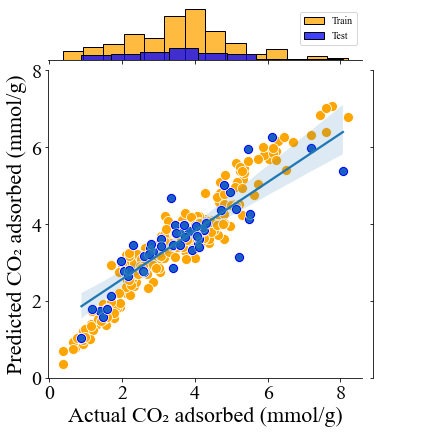

In [68]:
# Fitting HDPC dataset Regression with optimized XGB

import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


model =  XGBRegressor(colsample_bytree = 1, eta = 0.05, eval_metric = 'rmse', 
                        max_depth = 4, n_estimators = 100, seed = 42, subsample = 0.5)


model.fit(x_train, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train,y_train)
print("The training R2 is: %.3f" % model.score(x_train, y_train))
print("The test R2 is: %.3f "% model.score(x_test, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt


y_predicted = model.predict(x_test)

# The mean squared error & Variance
print("MSE: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))


#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid(y_test, y_predicted)
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)
plt.ylim(0, 8)
plt.xlim(0, 8)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", fontsize =22, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])
plt.locator_params(tight=None, nbins=5)

plt.show()

The training R2 is: 0.921
The test R2 is: 0.772 
MSE: 0.501
RMSE: 0.708
The mean training accuracy is: 0.672


C:\Users\msuva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


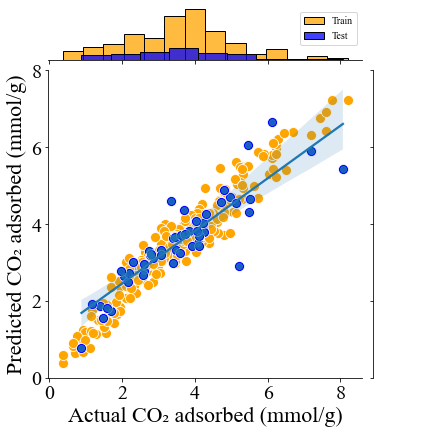

In [69]:
# Fitting HDPC dataset Regression with LGB

import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


model =  LGBMRegressor(boosting_type = 'dart', colsample_bytree = 1, learning_rate = 0.2,
                        max_depth = 4, n_estimators = 300, num_leaves = 5, reg_lambda = 0.8, subsample = 1)


model.fit(x_train, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train,y_train)
print("The training R2 is: %.3f" % model.score(x_train, y_train))
print("The test R2 is: %.3f "% model.score(x_test, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt


y_predicted = model.predict(x_test)

# The mean squared error & Variance
print("MSE: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))


#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid(y_test, y_predicted)
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)
plt.ylim(0, 8)
plt.xlim(0, 8)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", fontsize =22, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])
plt.locator_params(tight=None, nbins=5)

plt.show()


